In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [15]:
link = 'https://drive.google.com/open?id=1pIFDyOc9s4qivYy8iWve9tYeqTj71Qp5' # The shareable link
fluff, id = link.split('=')
print (id) # verify that you have everything after '='

1pIFDyOc9s4qivYy8iWve9tYeqTj71Qp5


### Data Exploration

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('NPS.csv')  
df = pd.read_csv('NPS.csv', header=1, encoding='utf-8', delimiter=',', engine='python')

In [18]:
#df = pd.read_csv('NPS.csv', header=1, encoding='utf-8', delimiter=',', engine='python')
df.head()

,Id,Category,Verbatim
0,1,Product Features,Could use some upgrades
1,2,Usability,Because your asking me to take a stupid survey...
2,3,Reliability,There is no service in the Crowders Mountain a...
3,4,Reliability,tracking drivers
4,5,Reliability,- Constantly losing bluetooth connection - Poo...


In [0]:
df = df[['Category','Verbatim']]

In [20]:
df['Category'].unique()

array(['Product Features', 'Usability', 'Reliability', 'Performance',
       'Contract', 'Customer service', 'Sales'], dtype=object)

In [0]:
main_categories = ['Product Features', 
                   'Usability', 
                   'Reliability', 
                   'Performance', 
                   'Contract', 
                   'Customer service', 
                   'Sales'
                   ]

In [22]:
df_stats = df.groupby(['Category']).count()
df_stats.columns = ['Count']
df_stats

,Count
Category,
Contract,1051
Customer service,3096
Performance,836
Product Features,2723
Reliability,5792
Sales,200
Usability,3494


In [23]:
main_categories.sort()
main_categories

['Contract',
 'Customer service',
 'Performance',
 'Product Features',
 'Reliability',
 'Sales',
 'Usability']

In [24]:
df_stats['category'] = main_categories
df_stats

,Count,category
Category,,
Contract,1051,Contract
Customer service,3096,Customer service
Performance,836,Performance
Product Features,2723,Product Features
Reliability,5792,Reliability
Sales,200,Sales
Usability,3494,Usability


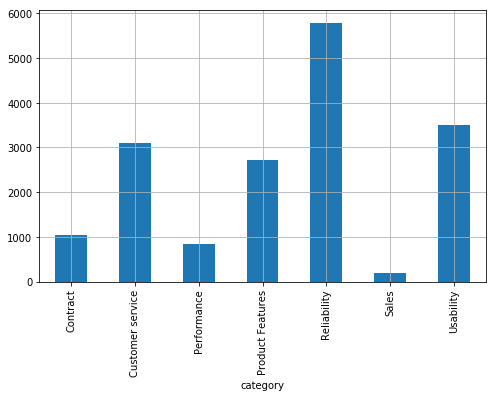

In [25]:
df_stats.plot(x = 'category', 
              y = 'Count', 
              kind = 'bar', 
              legend = False, 
              grid = True, 
              figsize = (8,5))

In [26]:
df.head(5)

,Category,Verbatim
0,Product Features,Could use some upgrades
1,Usability,Because your asking me to take a stupid survey...
2,Reliability,There is no service in the Crowders Mountain a...
3,Reliability,tracking drivers
4,Reliability,- Constantly losing bluetooth connection - Poo...


### Text Representation

Use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives:
* sublinear_df is set to True to use a logarithmic form for frequency.
* min_df is the minimum numbers of documents a word must be present in to be kept.
* norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.
* ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.
* stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True
                        ,min_df=2
                        ,norm='l2'
                        ,encoding='latin-1'
                        ,ngram_range=(1, 2)
                        ,stop_words='english')

In [28]:
features = tfidf.fit_transform(df['Verbatim']).toarray()
labels = df['Category']
features.shape

(17192, 13614)

In [0]:
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
                                            df['Verbatim']
                                            ,df['Category']
                                            ,random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [31]:
print(clf.predict(count_vect.transform(["The vehicles are not in the location they are supposed to be"])))

['Reliability']


In [32]:
df[df['Verbatim'] == "The vehicles are not in the location they are supposed to be "]

,Category,Verbatim
14,Reliability,The vehicles are not in the location they are ...


### Model Selection
We will benchmark the following four models:
* Logistic Regression
* (Multinomial) Naive Bayes
* Linear Support Vector Machine
* Random Forest

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [0]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [0]:
CV = 5

In [36]:
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

In [0]:
import seaborn as sns

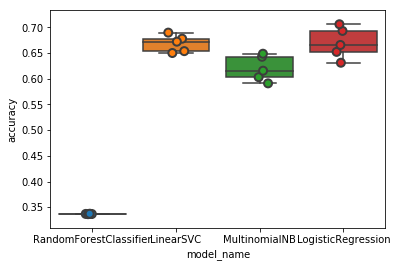

In [38]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [39]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.668572
LogisticRegression        0.669507
MultinomialNB             0.620121
RandomForestClassifier    0.336959
Name: accuracy, dtype: float64

### Model Evaluation

In [0]:
model = LogisticRegression(random_state=0)

In [41]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
                                                                            features
                                                                            ,labels
                                                                            ,df.index
                                                                            ,test_size=0.33
                                                                            ,random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
from sklearn.metrics import confusion_matrix

[[ 214   33    2   18   43    0   23]
 [   7  818    8   28  181    1   36]
 [   3    5  107   20  121    0   22]
 [  10   55    5  402  297    0   98]
 [   5  123   17  132 1529    0   91]
 [   2   22    0    4   28    4    1]
 [   3   24    1  107  213    0  811]]


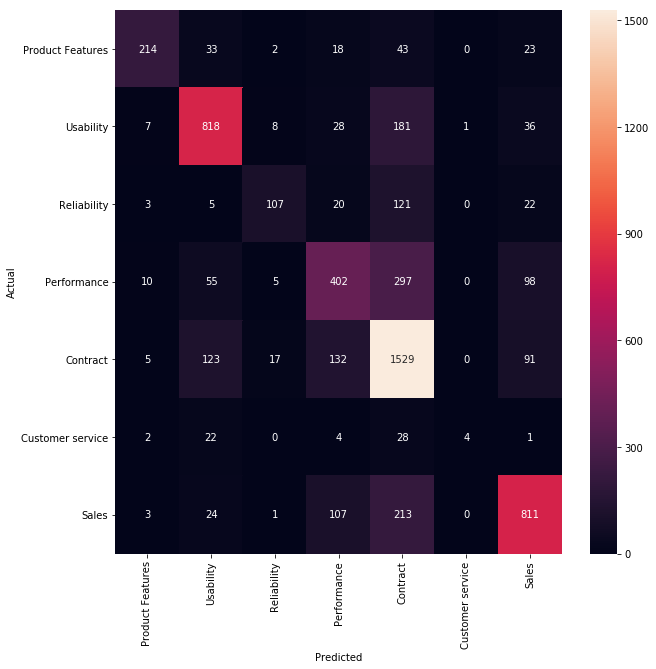

In [43]:
conf_mat = confusion_matrix(y_test, y_pred, main_categories)
print(conf_mat)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticklabels(main_categories)
ax.set_yticklabels(main_categories)
sns.heatmap(conf_mat
            ,annot=True
            ,fmt='d'
            ,xticklabels=df['Category'].unique()
            ,yticklabels=df['Category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [44]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

                  precision    recall  f1-score   support

Product Features       0.88      0.64      0.74       333
       Usability       0.76      0.76      0.76      1079
     Reliability       0.76      0.38      0.51       278
     Performance       0.57      0.46      0.51       867
        Contract       0.63      0.81      0.71      1897
Customer service       0.80      0.07      0.12        61
           Sales       0.75      0.70      0.72      1159

        accuracy                           0.68      5674
       macro avg       0.74      0.55      0.58      5674
    weighted avg       0.69      0.68      0.68      5674

